In [ ]:
!pip install python-chess

In [1]:
import random
import chess
from IPython.display import SVG, display
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

In [2]:
def play_random(fen):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)
    
    # And then randomly pick a legal move:
    move = random.choice(list(board.legal_moves))

    # Now we turn our move into a string, return it and call it a day!
    return str(move)

In [3]:
def isDiff_from_last(cur, las):
    cur =str(cur)
    las =str(las)
    # print("cur: ", cur[0:2], "las: ", las[2:4])
    # print("result: ", cur[0:2] != las[2:4])
    if cur[0:2] == las[2:4] and cur[2:4] == las[0:2]:
        return False
    return True

In [4]:
svgarr = []
# Our play function accepts whatever strategy our AI is using, like play_random from above
def play_game(ai_function):
    board = chess.Board()
    l_user_move = None
    l_ai_move = None
    turn = 0
    while board.outcome() is None:
        # We print out the board as an SVG
        svgarr.append((SVG(board._repr_svg_())))
        

        # If it's white's turn, we have the user play
        if board.turn == chess.WHITE:
            # user_move = input('Your move: ')
            # if user_move == 'quit':
            #     break
            # # The move a user puts in isn't a valid move, we keep prompting them for a valid move
            # while user_move not in [str(move) for move in board.legal_moves]:
            #     print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
            #     user_move = input('Your move: ')
            user_move = play_random(board.fen())
            # while not isDiff_from_last(user_move, l_user_move):
            #     #print(f'cur: {user_move}, las: {l_user_move}')
            #     user_move = play_random(board.fen())
            print(f'{turn}.user move: {user_move}')
            board.push_san(user_move)
            l_user_move = user_move

        # If it's black's turn, we have the AI play
        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            # while not isDiff_from_last(ai_move, l_ai_move):
            #     #print(f'cur: {ai_move}, las: {l_ai_move}')
            #     ai_move = ai_function(board.fen())
            print(f'{turn}.AI move: {ai_move}')
            board.push_san(ai_move)
            l_ai_move = ai_move
        turn+=1
        #print(turn)
    print(board.outcome())

In [5]:
# Lets code up a simple function to turn our chess pieces into one-hot encodings:
# enumerate return every single item as a tuble with first element is index and 
# second element is value at index started with index 0
def one_hot_encode_piece(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

# Let's test on a black bishop
#one_hot_encode_piece('b')

In [6]:
# Now lets use that function to encode our entire board

def encode_board(board):
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    material_dict = {
        'p': -1,
        'b': -3.5,
        'n': -3,
        'r': -5,
        'q': -9,
        'k': -4,
        'K': 4,
        '.': 0,
        'P': 10,
        'B': 3.5,
        'N': 3,
        'R': 5,
        'Q': 9,
    }
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            # print(piece)
            row_list.append(material_dict.get(piece))
        board_list.append(row_list)
    return np.array(board_list)

# Let's test on the starting board
#encode_board(chess.Board())

In [7]:
# Great! We can now use this function to get any board state ready for our model!
# We'll use pandas to pull in all our training data

train_df = pd.read_csv('data/train.csv', index_col='id')

# We'll only use the first 10000 examples so things run fast,
# but you'll get better performance if you remove this line
train_df = train_df[:55000]

# We'll also grab the last 1000 examples as a validation set
val_df = train_df[-1000:]
#train_df.head()

In [8]:
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

# We'll stack all our encoded boards into a single numpy array
X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']


X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

In [9]:
y_train

id
80091      0.0
18578   -131.0
11580   -490.0
72805   -574.0
74310      0.0
         ...  
16261    197.0
37580    604.0
24209   -300.0
17754     13.0
7047    -450.0
Name: black_score, Length: 55000, dtype: float64

In [10]:
# With the Keras Sequential model we can stack neural network layers together
model = Sequential([
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1),
])

model.compile(optimizer='adam',loss='mean_squared_error')

In [11]:
# To test things out, let's train for 20 epochs and see how our model is doing
history = model.fit(X_train,y_train,epochs=50,validation_data=(X_val, y_val))

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 147112.0781 - val_loss: 91595.3438
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 98641.3281 - val_loss: 75359.1562
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 80219.4219 - val_loss: 68301.4141
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 70892.4609 - val_loss: 56965.8047
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 69573.2188 - val_loss: 56731.8125
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 59434.7070 - val_loss: 46786.6133
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 54271.2031 - val_loss: 42034.1562
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 52936.9414 - val_loss: 42764.6133
Epoch 9/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 50971.2891 - val_loss: 41396.9414
Epoch 10/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 47103.1250 - val_loss: 37882.5703
Epoch 11/50
1719/1719 ━━━━━━━━━━━━━━━━

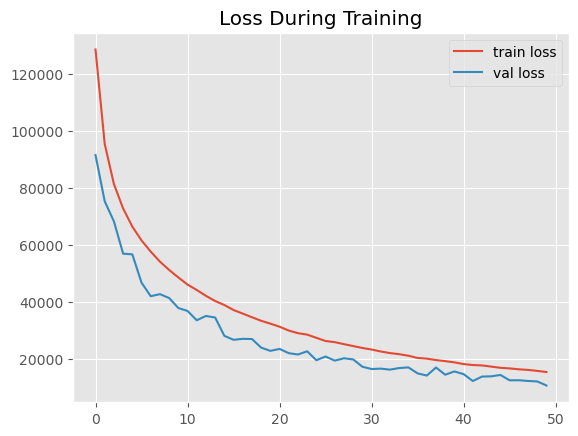

In [12]:
# Lets plot the history of our training session to see how things progressed over time
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

In [13]:
def play_nn(fen, player='b'):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    # And then evaluate all legal moves
    best_move = ''
    worst_move = ''
    minScore = float('inf')
    maxScore = float('-inf')

    moves = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        input_vector = encode_board(str(candidate_board)).astype(np.int32)
        
        # This is where our model gets to shine! It tells us how good the resultant score board is for black:
        score = model.predict(np.expand_dims(input_vector, axis=0), verbose=0)[0][0]
        if score > maxScore:
            best_move = move
            maxScore = score
        elif score < minScore:
            worst_move = move
            minScore = score
        # moves.append((score, move))
        # if show_move_evaluations:
        #     print(f'{move}: {score}')
    
    # By default sorting our moves will put the lowest scores at the top.
    # This would give us the right answer if we were playing as white,
    # but if we're playing as black we want to reverse things (then grab the first move):
    
    # if(player=='b'):
    #     return str(worst_move)
    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

In [14]:
### Now that we have a policy, we can play against it!

play_game(play_nn)


0.user move: b2b4
1.AI move: a7a5
2.user move: a2a4
3.AI move: d7d5
4.user move: a1a3
5.AI move: b7b5
6.user move: a3d3
7.AI move: c7c5
8.user move: b4c5
9.AI move: b8c6
10.user move: c1b2
11.AI move: d5d4
12.user move: d3h3
13.AI move: b5a4
14.user move: f2f4
15.AI move: c6e5
16.user move: b1a3
17.AI move: e7e6
18.user move: a3c4
19.AI move: g8e7
20.user move: c2c3
21.AI move: d4c3
22.user move: g2g4
23.AI move: c3d2
24.user move: d1d2
25.AI move: e7c6
26.user move: g4g5
27.AI move: h8g8
28.user move: h3f3
29.AI move: c6d4
30.user move: e2e4
31.AI move: d4f3
32.user move: e1e2
33.AI move: f3d2
34.user move: b2c1
35.AI move: d2e4
36.user move: f1g2
37.AI move: c8b7
38.user move: f4e5
39.AI move: d8g5
40.user move: c4b2
41.AI move: g5e5
42.user move: b2a4
43.AI move: e8d7
44.user move: g2f3
45.AI move: g7g6
46.user move: a4c3
47.AI move: b7c8
48.user move: c3d1
49.AI move: d7e8
50.user move: f3h5
51.AI move: g8h8
52.user move: c1e3
53.AI move: a5a4
54.user move: e3f2
55.AI move: a4a3
56

In [15]:
import os
from IPython.display import SVG
import cairosvg
#os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/7.0_1"
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/Cellar/ffmpeg/7.0_1/bin/ffmpeg"
from moviepy.editor import ImageSequenceClip
from PIL import Image

In [19]:
# List of IPython.display.SVG objects
# svg_objects = [
#     SVG('<svg xmlns="http://www.w3.org/2000/svg" width="100" height="100"><circle cx="50" cy="50" r="40" stroke="black" stroke-width="3" fill="red" /></svg>'),
#     SVG('<svg xmlns="http://www.w3.org/2000/svg" width="100" height="100"><rect width="100" height="100" style="fill:blue;stroke-width:3;stroke:black" /></svg>'),
#     # Add more SVG objects as needed
# ]

# Define paths
svg_folder = "svg_folder"
png_folder = "png_folder"
output_video = "output.mp4"

# Ensure the folders exist
os.makedirs(svg_folder, exist_ok=True)
os.makedirs(png_folder, exist_ok=True)

# Step 1: Save SVG data to files
def save_svg(svg_obj, path):
    with open(path, 'w') as file:
        file.write(svg_obj.data)

for i, svg_obj in enumerate(svgarr):
    svg_path = os.path.join(svg_folder, f'image{i:04d}.svg')
    save_svg(svg_obj, svg_path)

# Step 2: Convert SVG to PNG with uniform size
def convert_svg_to_png(svg_path, png_path, width, height):
    cairosvg.svg2png(url=svg_path, write_to=png_path, output_width=width, output_height=height)

# Determine desired width and height for the PNGs
desired_width = 1024  # Change this to your desired width
desired_height = 1024  # Change this to your desired height

svg_files = sorted([f for f in os.listdir(svg_folder) if f.endswith('.svg')])

for svg_file in svg_files:
    svg_path = os.path.join(svg_folder, svg_file)
    png_path = os.path.join(png_folder, f'{os.path.splitext(svg_file)[0]}.png')
    convert_svg_to_png(svg_path, png_path, desired_width, desired_height)

# Step 3: Create a video from PNG files
png_files = sorted([os.path.join(png_folder, f) for f in os.listdir(png_folder) if f.endswith('.png')])

clip = ImageSequenceClip(png_files, fps=30)
clip.write_videofile(output_video, codec='libx264')

print(f"Video created: {output_video}")


Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
Video created: output.mp4
